In [1]:
import re
import time
import json
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pyodbc
from dotenv import load_dotenv
import os

In [2]:
def convert_price_to_pkr(price_str, exchange_rate=280.41):
    """Convert USD price to PKR"""
    try:
        price_match = re.search(r'[\d,]+\.?\d*', price_str)
        if price_match:
            price_usd = float(price_match.group().replace(',', ''))
            price_pkr = price_usd * exchange_rate
            return {
                'price_usd': f"${price_usd:.2f}",
                'price_pkr': f"Rs.{price_pkr:.2f}"
            }
        return {'price_usd': price_str, 'price_pkr': 'N/A'}
    except:
        return {'price_usd': price_str, 'price_pkr': 'N/A'}

def setup_driver(headless=True):
    options = Options()
    if headless:
        options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_argument(
        'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    )
    driver = webdriver.Chrome(options=options)
    return driver
    
def extract_product_details(product_element, exchange_rate=280.41):
    """Extract key product details"""
    try:
        html = product_element.get_attribute('outerHTML')
        soup = BeautifulSoup(html, 'html.parser')

        # Product name
        name_elem = soup.find('a', title=True) or soup.find('h3')
        name = name_elem.get_text(strip=True) if name_elem else 'N/A'

        # Price
        price_elem = soup.find('span', class_=lambda x: x and 'price' in x.lower())
        price = price_elem.get_text(strip=True) if price_elem else 'N/A'
        price_data = convert_price_to_pkr(price, exchange_rate)

        # URL
        url_elem = soup.find('a', href=True)
        url = url_elem['href'] if url_elem else 'N/A'
        if not url.startswith('http') and url != 'N/A':
            url = 'https://www.banggood.com' + url

        # Rating
        rating_elem = soup.find('span', class_=lambda x: x and 'star' in x.lower())
        rating = rating_elem.get_text(strip=True) if rating_elem else 'N/A'

        # Reviews
        review_elem = soup.find('span', class_=lambda x: x and 'review' in x.lower())
        reviews = review_elem.get_text(strip=True) if review_elem else 'N/A'

        return {
            'name': name,
            'price_usd': price_data['price_usd'],
            'price_pkr': price_data['price_pkr'],
            'reviews': reviews,
            'url': url
        }

    except Exception as e:
        print(f"Error extracting product: {e}")
        return None

def scrape_rc_category(driver, url, category_name, exchange_rate=280.41):
    print(f"\nScraping {category_name}...")
    driver.get(url)
    time.sleep(5) 

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "li[data-product-id], .product-item, .goods-item"))
        )
    except:
        print("Timeout waiting for products, proceeding anyway...")

    for _ in range(5):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

    selectors = [
        (By.CSS_SELECTOR, 'li[data-product-id]'),
        (By.CSS_SELECTOR, 'div[data-product-id]'),
        (By.CLASS_NAME, 'product-item'),
        (By.CLASS_NAME, 'goods-item'),
    ]

    product_elements = []
    for by, selector in selectors:
        try:
            elements = driver.find_elements(by, selector)
            if elements:
                product_elements = elements
                break
        except:
            continue

    if not product_elements:
        print(f"No products found for {category_name}")
        return []

    products = []
    for elem in product_elements[:50]:
        data = extract_product_details(elem, exchange_rate)
        if data:
            products.append(data)

    print(f"Extracted {len(products)} products from {category_name}")
    return products

def json_to_csv(json_file='bike_products.json', csv_file='bike_products.csv'):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    rows = []
    for category, products in data.items():
        for product in products:
            rows.append({
                'category': category,
                'name': product.get('name', 'N/A'),
                'price_usd': product.get('price_usd', 'N/A'),
                'price_pkr': product.get('price_pkr', 'N/A'),
                'reviews': product.get('reviews', 'N/A'),
                'url': product.get('url', 'N/A')
            })

    df = pd.DataFrame(rows)
    df.to_csv(csv_file, index=False, encoding='utf-8-sig')
    print(f"CSV saved: {csv_file} ({len(df)} products)")
    return df

In [3]:
def analysis():
    # Load the dataset
    df = pd.read_csv('bike_products.csv')
    categories = df['category'].unique()

    # Create a figure with 2 rows and 2 columns of subplots
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    fig.tight_layout(pad=5.0)

    ### 1. Price Distribution Per Category (Line Plot)
    ax = axs[0, 0]
    for cat in categories:
        prices = df[df['category'] == cat]['price_pkr'].sort_values().values
        ax.plot(range(len(prices)), prices, marker='o', label=cat)
    ax.set_title('Price Distribution per Category')
    ax.set_xlabel('Product Index (sorted by price)')
    ax.set_ylabel('Price (PKR)')
    ax.legend()
    ax.grid(True)

    ### 2. Price vs Reviews (Scatter Plot)
    ax = axs[0, 1]
    ax.scatter(df['price_pkr'], df['reviews'], alpha=0.6, color='orange')
    ax.set_title('Price vs Reviews')
    ax.set_xlabel('Price (PKR)')
    ax.set_ylabel('Number of Reviews')
    ax.grid(True)

    ### 3. Top 10 Most Reviewed Products (Horizontal Bar)
    ax = axs[1, 0]
    top_reviews = df.sort_values('reviews', ascending=False).head(10)
    ax.barh(top_reviews['name'], top_reviews['reviews'], color='skyblue')
    ax.set_title('Top 10 Most Reviewed Products')
    ax.set_xlabel('Number of Reviews')
    ax.set_ylabel('Product Name')
    ax.invert_yaxis()  # highest on top
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    ### 4. Number of Products per Category (Vertical Bar)
    ax = axs[1, 1]
    category_counts = df['category'].value_counts()
    ax.bar(category_counts.index, category_counts.values, color='lightgreen')
    ax.set_title('Number of Products per Category')
    ax.set_xlabel('Category')
    ax.set_ylabel('Number of Products')
    ax.set_xticklabels(category_counts.index, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


In [4]:
def load_to_db(df, conn, table_name):
    if df.empty:
        print("Empty!")
        return

    cursor = conn.cursor()

    type_map_sql = {
        'int64': 'INT',
        'float64': 'FLOAT',
        'object': 'NVARCHAR(MAX)',
        'datetime64[ns]': 'DATETIME'
    }

    columns_sql = []
    for col, dtype in df.dtypes.items():
        sql_type = type_map_sql.get(str(dtype), "NVARCHAR(MAX)")
        columns_sql.append(f"[{col}] {sql_type}")

    create_table_query = f"""
        IF OBJECT_ID('{table_name}', 'U') IS NOT NULL DROP TABLE {table_name};
        CREATE TABLE {table_name} ({', '.join(columns_sql)});
    """
    cursor.execute(create_table_query)
    conn.commit()

    placeholders = ", ".join(["?"] * len(df.columns))
    insert_query = f"INSERT INTO {table_name} VALUES ({placeholders})"
    cursor.executemany(insert_query, df.values.tolist())
    conn.commit()


Scraping Bike Computer...
Extracted 24 products from Bike Computer

Scraping Bike HeadLamps...
Extracted 50 products from Bike HeadLamps

Scraping Bike Pumps & Tire...
Extracted 31 products from Bike Pumps & Tire

Scraping Bike Holder...
Extracted 50 products from Bike Holder

Scraping Bike Accessories...
Extracted 50 products from Bike Accessories
CSV saved: bike_products.csv (205 products)
WebDriver closed.


C:\Users\hisha\AppData\Local\Temp\ipykernel_14056\100271476.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(category_counts.index, rotation=45)


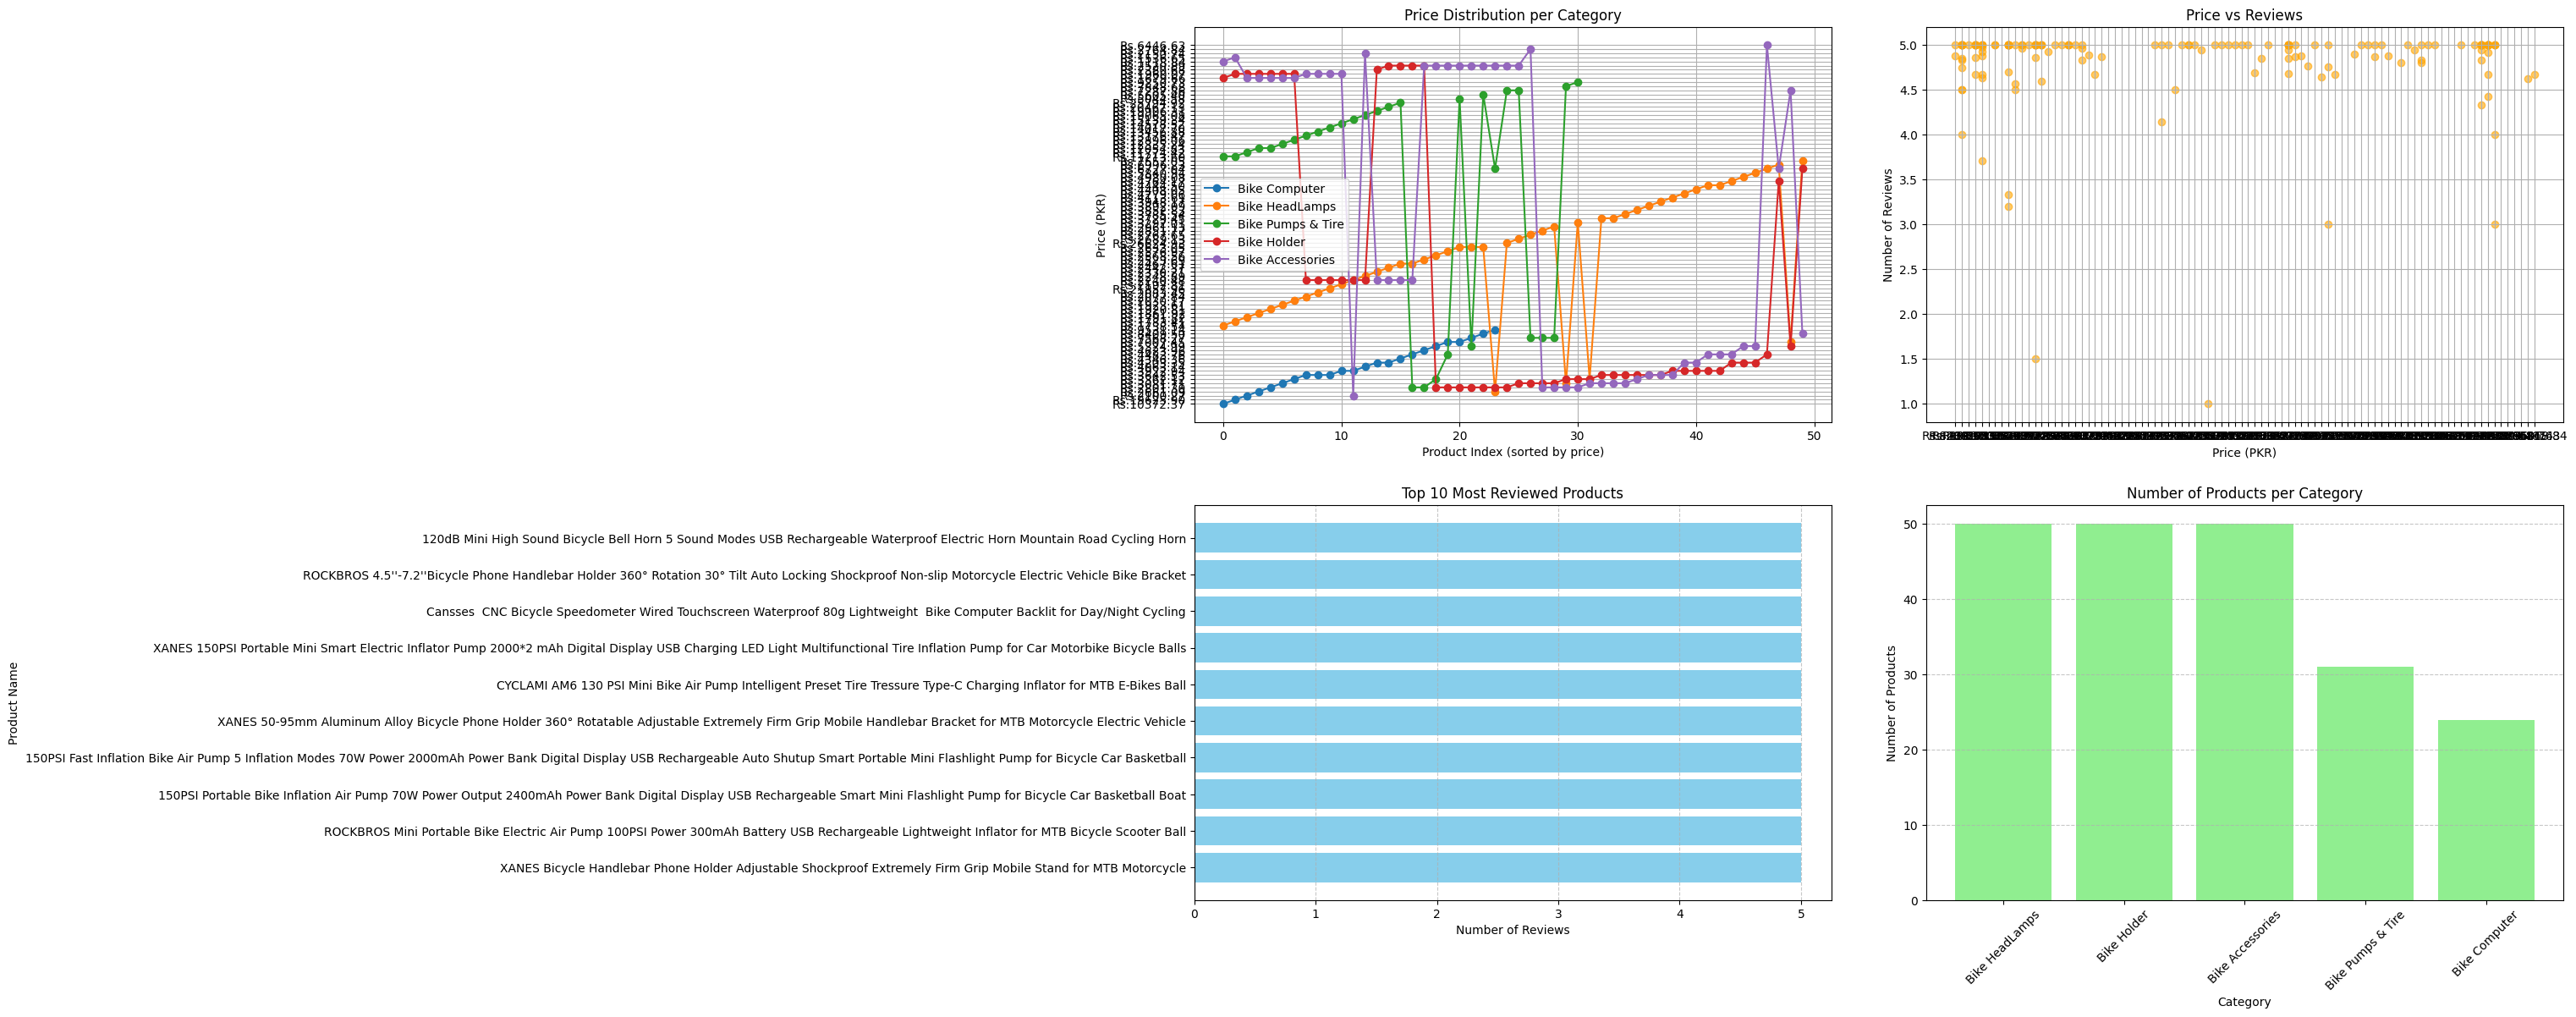

In [5]:
def main(exchange_rate=280.41, headless=True):
    driver = setup_driver(headless=headless)
    try:
        categories = {
            'Bike Computer': 'https://www.banggood.com/Wholesale-Bike-Computer-ca-6005.html?bid=2107020403&from=nav',
            'Bike HeadLamps': 'https://www.banggood.com/Wholesale-Bike-HeadLamps-ca-18097.html?bid=2107020402&from=nav',
            'Bike Pumps & Tire': 'https://www.banggood.com/Wholesale-Bike-Pumps-and-Tire-ca-18104.html?bid=2107020404&from=nav',
            'Bike Holder': 'https://www.banggood.com/Wholesale-Bike-Holder-ca-18101.html?bid=2107020405&from=nav',
            'Bike Accessories': 'https://www.banggood.com/Wholesale-Bike-Accessories-ca-6007.html?bid=2107020407&from=nav'
        }

        all_products = {}
        for cat_name, url in categories.items():
            products = scrape_rc_category(driver, url, cat_name, exchange_rate)
            all_products[cat_name] = products

        # Save JSON
        with open('bike_products.json', 'w', encoding='utf-8') as f:
            json.dump(all_products, f, indent=2, ensure_ascii=False)

        # Save CSV
        df = json_to_csv('bike_products.json', 'bike_products.csv')

        return all_products, df

    finally:
        driver.quit()
        print("WebDriver closed.")


if __name__ == "__main__":
    all_products, df = main(exchange_rate=280.41, headless=True)
    analysis()

    TABLE_NAME = "dbo.Bikes"

    # SQL Server connection
    SERVER_NAME = "DESKTOP-M3R93F9"
    DB_NAME = "BikeStore"

    conn_str = (
        "DRIVER={ODBC Driver 17 for SQL Server};"
        f"SERVER={SERVER_NAME};"
        "DATABASE=master;"
        "Trusted_Connection=yes;"
    )

    conn = pyodbc.connect(conn_str)
    conn.autocommit = True
    cursor = conn.cursor()
    cursor.execute(f"IF NOT EXISTS (SELECT * FROM sys.databases WHERE name = '{DB_NAME}') CREATE DATABASE {DB_NAME};")
    conn.close()

    conn = pyodbc.connect(
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={SERVER_NAME};"
        f"DATABASE={DB_NAME};"
        "Trusted_Connection=yes;"
    )

    load_to_db(df, conn, TABLE_NAME)